# Calculating Temporal Averages with GeoCAT-comp vs Xarray

With temporally large datasets, computing seasonal and annual averages are a great ways to summarize the data and make it easier to manage and understand. You may want to take hourly, daily, or monthly data and compute seasonal or annual averages.

## Challenges
When using data that has a daily or finer resolution (e.g. hourly), calculating an annual average is simple. Every day and hour has the same length, so an unweighted average will work.

But when using data that is monthly, things can get a bit tricky. Not every month is created equal. February has 28 or 29 days and March has 31 days. Since monthly data has one value for each month, those points can't be averaged in the usual way. A weighted average is needed.

While it is tempting to quickly compute monthly to annual averages with `Xarray`'s `resample` or `groupby` functions, we need to be careful to specify the weights. Unfortunately, `Xarray` doesn't support weighted `resample` or `groupby` at the time this post was created, but `geocat-comp.climatology_average` builds upon `Xarray` to compute the weights for you.

Below is a plot showing the difference between computing the winter average temperature from monthly data using the incorrect unweighted average and the correct weighted average.

![xarray_vs_geocat_climatology.png](../images/xarray_vs_geocat_climatology.png)

## Demonstration
In this post, I'll show how to compute seasonal averages from monthly data the naive way (with unweighted averages) and the correct way (with weighted averages).

### Imports

In [1]:
import cartopy as cart
import geocat.comp as gc
import geocat.viz as gv
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

### Helper function to make all of the plots the same way but with different data

In [2]:
def custom_plot(data, title):
    # Generate figure (set its size (width, height) in inches)
    plt.figure(figsize=(14, 7))

    # Generate axes, using Cartopy
    projection = cart.crs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')

    # Draw coastlines
    ax.coastlines()
    ax.gridlines(alpha=0.5)

    if 'Difference' in title:
        # Contourf-plot data (for filled contours)
        p = data.plot.contourf(
            ax=ax,
            vmin=-0.1,
            vmax=0.1,
            levels=11,
            cmap='bwr',
            add_colorbar=False,
            transform=projection,
            extend='neither',
        )

        # Add horizontal colorbar
        cbar = plt.colorbar(p, orientation='horizontal', shrink=0.5)
        cbar.ax.tick_params(labelsize=14)
        cbar.set_ticks(np.linspace(-0.1, 0.1, 6))
    else:
        # Contourf-plot data (for filled contours)
        p = data.plot.contourf(
            ax=ax,
            vmin=20,
            vmax=30,
            levels=11,
            cmap='inferno',
            add_colorbar=False,
            transform=projection,
            extend='neither',
        )

        # Add horizontal colorbar
        cbar = plt.colorbar(p, orientation='horizontal', shrink=0.5)
        cbar.ax.tick_params(labelsize=14)
        cbar.set_ticks(np.linspace(20, 30, 6))

    # Use geocat.viz.util convenience function to set axes tick values
    gv.set_axes_limits_and_ticks(
        ax,
        xlim=(-180, -70),
        ylim=(-20, 20),
        xticks=np.arange(-180, -70, 10),
        yticks=np.arange(-20, 20, 5),
    )

    # Use geocat.viz.util convenience function to make plots look like NCL plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gv.add_major_minor_ticks(ax, labelsize=12)

    # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
    gv.set_titles_and_labels(
        ax,
        maintitle=title,
        lefttitle="Winter Average",
        lefttitlefontsize=16,
        righttitle=data.units,
        righttitlefontsize=16,
        xlabel="",
        ylabel="",
    )

    # Show the plot
    plt.show()

### Read in and format data
The data we will be using is a subset from RDA dataset ds277.0 - 'NOAA NCEP Optimum Interpolation Sea Surface Temperature Analysis'. It contains monthly average sea surface temperatures over the eastern equitorial Pacific from 1982 to 1986. We will be computing seasonal averages from this data and comparing the two different methods for doing this calculation.

In [3]:
ds = xr.open_dataset('603321.sst.sst.mnmean.nc')
ds = ds.sst  # Pull out the sea surface temperature data
ds = ds.isel(
    time=range(1, 49)
)  # Remove the first data point so that we have an equal number of data points from each month

### The incorrect way to compute seasonal averages from monthly data

It's easy to compute an unweighted average using `xarray` functionality; however, this generates inaccurate results. Here is what the ***incorrect*** way of doing this looks like. Notice that the result has a `month` dimension. These months are the start of each quarter. The quarters are the meteorological seasons. (e.g. December, January, and February for winter)

In [4]:
# Resample the data by quarters, compute the average, and group by month.
seasonal_average_weighted_incorrectly = ds.groupby('time.season').mean()
seasonal_average_weighted_incorrectly

<xarray.DataArray 'sst' (season: 4, lat: 40, lon: 110)>
array([[[25.660833, 25.619997, 25.572502, ..., 26.779167, 26.494165,
         26.465834],
        [25.914999, 25.876663, 25.829168, ..., 27.035002, 26.868334,
         26.679167],
        [26.064165, 26.026667, 25.981667, ..., 27.000832, 26.989166,
         26.899164],
        ...,
        [28.206667, 28.167498, 28.148336, ..., 23.69333 , 23.731667,
         23.705002],
        [27.877502, 27.8225  , 27.790833, ..., 23.844164, 23.805834,
         23.6825  ],
        [27.518335, 27.458334, 27.4225  , ..., 23.766668, 23.775   ,
         23.638334]],

       [[27.340834, 27.276665, 27.225832, ..., 28.585833, 28.35    ,
         28.225832],
        [27.399168, 27.331665, 27.276667, ..., 28.417498, 28.280005,
         28.213333],
        [27.421667, 27.354164, 27.295   , ..., 28.247498, 28.249998,
         28.216665],
...
        [28.158333, 28.155   , 28.11167 , ..., 22.666666, 22.707499,
         22.724998],
        [27.8175  , 27.8125  , 27.760834, ..., 22.8975  , 22.81    ,
         22.76    ],
        [27.436666, 27.419168, 27.356668, ..., 22.8225  , 22.7325  ,
         22.658333]],

       [[27.836668, 27.792501, 27.725   , ..., 28.742498, 28.539167,
         28.454165],
        [27.945831, 27.901667, 27.828333, ..., 28.66333 , 28.4975  ,
         28.419165],
        [28.007498, 27.959997, 27.886667, ..., 28.534166, 28.47083 ,
         28.421667],
        ...,
        [26.004168, 25.980001, 26.002497, ..., 18.877499, 19.0925  ,
         19.121664],
        [25.459167, 25.431665, 25.445   , ..., 18.905832, 19.098333,
         19.135   ],
        [24.853333, 24.831667, 24.836664, ..., 18.72083 , 18.925   ,
         18.979166]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 19.5 18.5 17.5 16.5 15.5 ... -16.5 -17.5 -18.5 -19.5
  * lon      (lon) float32 180.5 181.5 182.5 183.5 ... 286.5 287.5 288.5 289.5
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (12/13)
    long_name:             Monthly Mean of Sea Surface Temperature
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    units:                 degC
    precision:             2
    var_desc:              Sea Surface Temperature
    ...                    ...
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    standard_name:         sea_surface_temperature
    cell_methods:          time: mean (monthly from weekly values interpolate...
    valid_range:           [-500 4000]

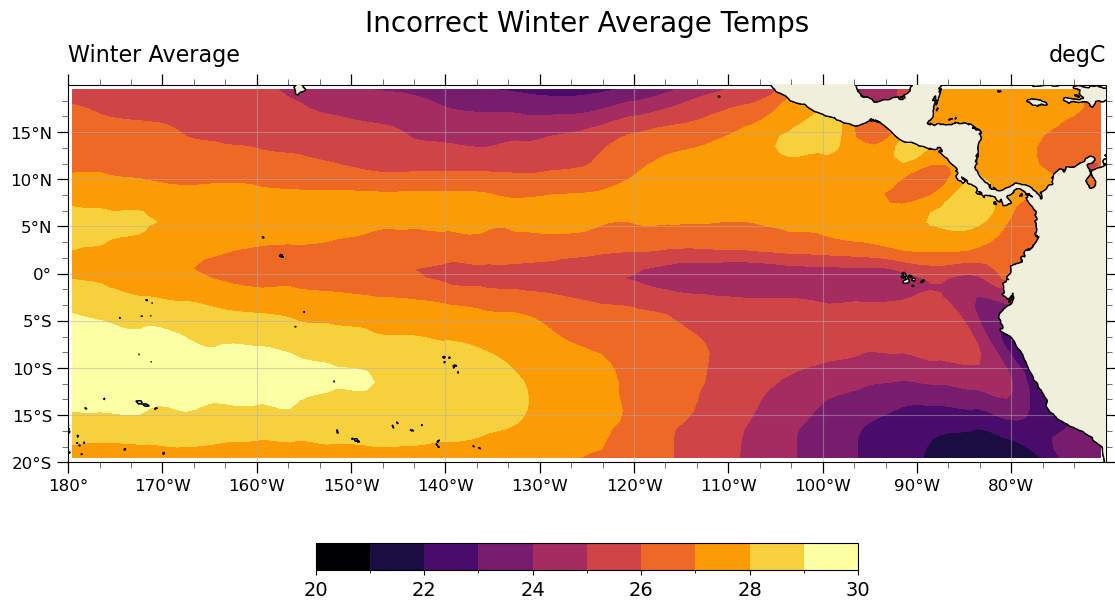

In [5]:
custom_plot(seasonal_average_weighted_incorrectly.isel(season=0), "Incorrect Winter Average Temps")

### The correct way to compute seasonal averages with xarray
Using GeoCAT's climatology average, we can calculate the average temperature for each season. Note that `climatology_average` requires that the datetime objects for the time dimension match a recognized frequency. More information about frequencies can be found [here](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). Luckily, our data is already in the correct format as shown below with each data point being at the start of a month.

In [6]:
# What the time dimension looks like before resampling
ds['time']

<xarray.DataArray 'time' (time: 48)>
array(['1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-01T00:00:00.000000000', '1982-04-01T00:00:00.000000000',
       '1982-05-01T00:00:00.000000000', '1982-06-01T00:00:00.000000000',
       '1982-07-01T00:00:00.000000000', '1982-08-01T00:00:00.000000000',
       '1982-09-01T00:00:00.000000000', '1982-10-01T00:00:00.000000000',
       '1982-11-01T00:00:00.000000000', '1982-12-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1983-02-01T00:00:00.000000000',
       '1983-03-01T00:00:00.000000000', '1983-04-01T00:00:00.000000000',
       '1983-05-01T00:00:00.000000000', '1983-06-01T00:00:00.000000000',
       '1983-07-01T00:00:00.000000000', '1983-08-01T00:00:00.000000000',
       '1983-09-01T00:00:00.000000000', '1983-10-01T00:00:00.000000000',
       '1983-11-01T00:00:00.000000000', '1983-12-01T00:00:00.000000000',
       '1984-01-01T00:00:00.000000000', '1984-02-01T00:00:00.000000000',
       '1984-03-01T00:00:00.000000000', '1984-04-01T00:00:00.000000000',
       '1984-05-01T00:00:00.000000000', '1984-06-01T00:00:00.000000000',
       '1984-07-01T00:00:00.000000000', '1984-08-01T00:00:00.000000000',
       '1984-09-01T00:00:00.000000000', '1984-10-01T00:00:00.000000000',
       '1984-11-01T00:00:00.000000000', '1984-12-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000', '1985-02-01T00:00:00.000000000',
       '1985-03-01T00:00:00.000000000', '1985-04-01T00:00:00.000000000',
       '1985-05-01T00:00:00.000000000', '1985-06-01T00:00:00.000000000',
       '1985-07-01T00:00:00.000000000', '1985-08-01T00:00:00.000000000',
       '1985-09-01T00:00:00.000000000', '1985-10-01T00:00:00.000000000',
       '1985-11-01T00:00:00.000000000', '1985-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 1985-12-01
Attributes:
    long_name:        Time
    actual_range:     [66443. 81357.]
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    bounds:           time_bnds

`climatology_average` takes in the data, the frequency for the averages (seasonal averages in this case), and the name of the time dimension. Note that the output now has a `season` dimension with strings representing the different months in each meteorological season.

In [7]:
seasonal_average_weighted_correctly = gc.climatology_average(ds, 'season', 'time')
seasonal_average_weighted_correctly

<xarray.DataArray (season: 4, lat: 40, lon: 110)>
array([[[25.67409912, 25.63332366, 25.5861487 , ..., 26.79141228,
         26.50703572, 26.4770631 ],
        [25.92753362, 25.88914068, 25.84166116, ..., 27.04451493,
         26.8777279 , 26.6890298 ],
        [26.07664777, 26.03883591, 25.99379444, ..., 27.00916852,
         26.99756192, 26.90800497],
        ...,
        [28.19288036, 28.15285272, 28.13371148, ..., 23.66407136,
         23.70063687, 23.67542865],
        [27.85914054, 27.80290802, 27.77116294, ..., 23.813268  ,
         23.77614912, 23.65379442],
        [27.49545653, 27.43415481, 27.39794947, ..., 23.73390508,
         23.74584418, 23.61058124]],

       [[27.34684689, 27.28241782, 27.23133097, ..., 28.58809725,
         28.35266246, 28.2284507 ],
        [27.40483624, 27.33706454, 27.28179298, ..., 28.4188851 ,
         28.28146696, 28.21524404],
        [27.42676562, 27.35918431, 27.29989059, ..., 28.24845055,
         28.25103166, 28.21790701],
...
        [28.15548862, 28.15217317, 28.1089941 , ..., 22.66494518,
         22.70562482, 22.72315176],
        [27.81464622, 27.80972794, 27.75820598, ..., 22.89592331,
         22.8080973 , 22.75817909],
        [27.43385804, 27.41646713, 27.35418436, ..., 22.82124959,
         22.7308145 , 22.65671145]],

       [[27.83785642, 27.79362592, 27.72601591, ..., 28.74423028,
         28.54131815, 28.45631811],
        [27.9465928 , 27.90238945, 27.82901055, ..., 28.6645321 ,
         28.49895535, 28.42090586],
        [28.00782921, 27.9603567 , 27.88697765, ..., 28.53510909,
         28.4720874 , 28.42302146],
        ...,
        [26.00365299, 25.97958746, 26.0021148 , ..., 18.87348859,
         19.08950491, 19.11881845],
        [25.45848824, 25.43115355, 25.44458745, ..., 18.90200509,
         19.09541132, 19.13249928],
        [24.85247188, 24.83101581, 24.83626334, ..., 18.71717014,
         18.92203252, 18.97653799]]])
Coordinates:
  * lat      (lat) float32 19.5 18.5 17.5 16.5 15.5 ... -16.5 -17.5 -18.5 -19.5
  * lon      (lon) float32 180.5 181.5 182.5 183.5 ... 286.5 287.5 288.5 289.5
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (12/13)
    long_name:             Monthly Mean of Sea Surface Temperature
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    units:                 degC
    precision:             2
    var_desc:              Sea Surface Temperature
    ...                    ...
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    standard_name:         sea_surface_temperature
    cell_methods:          time: mean (monthly from weekly values interpolate...
    valid_range:           [-500 4000]

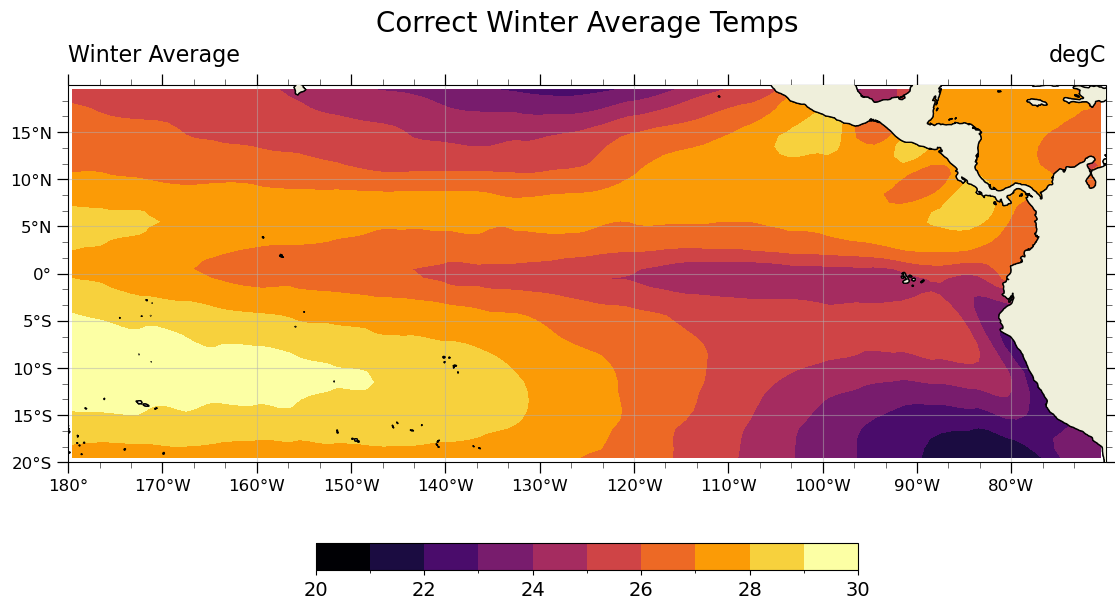

In [8]:
custom_plot(seasonal_average_weighted_correctly.isel(season=0), 'Correct Winter Average Temps')

## So what's the difference?
It is hard to see the difference between the correct and incorrect ways of caluclating the seasonal averages. If we plot the difference between the two results, the computational errors become easier to see.

In [9]:
diff = seasonal_average_weighted_correctly - seasonal_average_weighted_incorrectly

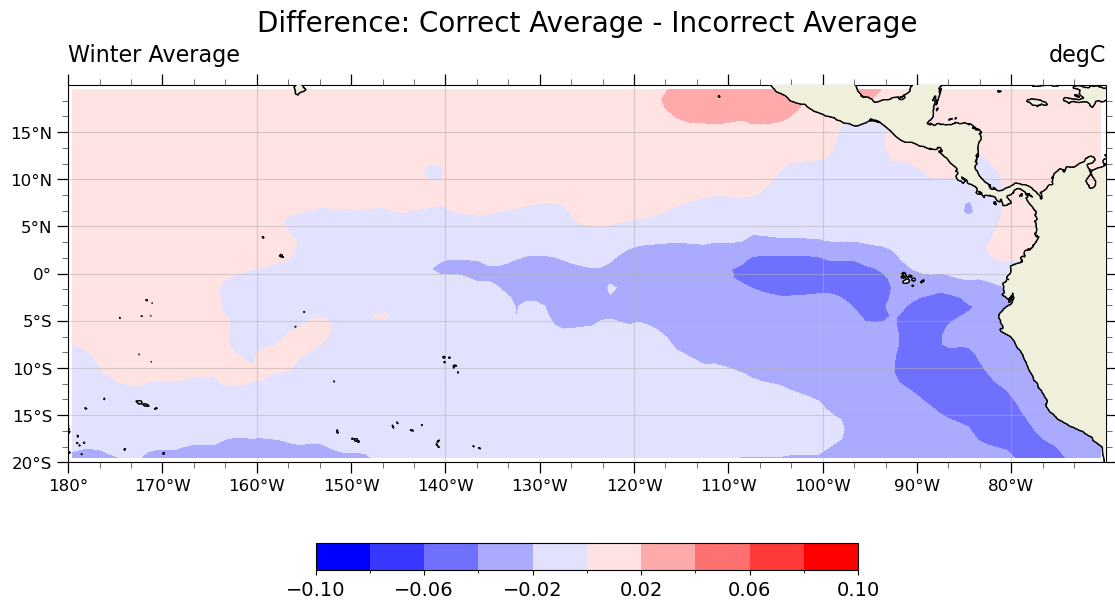

In [10]:
custom_plot(diff.isel(season=0), 'Difference: Correct Average - Incorrect Average')

## What we learned
The incorrect averages deviate from the correct averages by up to 0.1 degrees Celsius in this example, but it wasn't obvious before we computed the difference! While these differences are very small, they aren't small enough to be neglgible for scientific purposes. It's really easy to assume that an unweighted average will give you the correct climatology values and end up with hard to find errors in your calculations.

This example covered the correct way to compute seasonal climatologies from monthly data using GeoCAT-comp's `climatology_average` and the discrepancies of using unweighted averages. Not every calculation needs a weighted average, but be sure to consider what kind of average you need before doing your calculations to avoid a debugging headache!

## Additional Info
If you want finer control over the averaging than what GeoCAT-comp allows with `climatology_average`, check out [this post](https://docs.xarray.dev/en/stable/examples/monthly-means.html) from Xarray about computing seasonal averages from monthly means. This tutorial is a detailed explaination of the process that `climatology_average` is based on. We also discussed this same computational challenge in an [older blog post](https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/) before `climatology_average` was implemented that may be of interest.